# Optimization Strategy: Adam + L-BFGS

This notebook demonstrates and compares two common optimization strategies for training Physics-Informed Neural Networks (PINNs):
1.  **Adam Only:** Using the Adam optimizer for the entire training process.
2.  **Adam + L-BFGS:** A two-stage approach where Adam is used for initial training, followed by the L-BFGS optimizer for fine-tuning to achieve higher accuracy.

We will solve a simple first-order Ordinary Differential Equation (ODE) to clearly illustrate the difference in the final accuracy achieved by each strategy.

### Problem Definition

- **ODE:** 
  $$ \frac{dy}{dx} + y = 0 $$
- **Initial Condition (IC):** 
  $$ y(0) = 1 $$
- **Domain:** 
  $$ x \in [0, 5] $$
- **Analytical Solution:** 
  $$ y(x) = e^{-x} $$


  


In [1]:
import deepxde as dde
import numpy as np

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


### Step 1: Define the Problem

First, we define all the components of our ODE problem: the geometry, the ODE residual function, the initial condition, and the analytical solution which we will use for validation.

As a best practice, we'll write the `analytical_solution` function to be robust, handling both NumPy arrays (used by `dde.data.PDE` for generating test data) and backend Tensors (used during training for metric calculation).




In [4]:
# 1. Define the computational geometry
geom = dde.geometry.Interval(0.0, 5.0)

# 2. Define the ODE residual
def ode(x, y):
    # 對 1D，明確指定 i=0, j=0 最穩妥
    dy_dx = dde.grad.jacobian(y, x, i=0, j=0)
    return dy_dx + y

# 3. Define the initial condition
def at_x0(x, on_boundary):
    return on_boundary and np.isclose(x[0], 0.0)

bc_left = dde.DirichletBC(geom, lambda x: 1.0, at_x0)

# 4. Define the analytical solution for accuracy validation
def analytical_solution(x):
    # x 形狀為 (N,1)；回傳 (N,1)
    if isinstance(x, np.ndarray):
        return np.exp(-x[:, 0:1])
    else:
        return dde.backend.exp(-x[:, 0:1])


### Step 2: Setup the PINN Model

Now, we assemble the data object and define the neural network architecture. This `data` object and `net` architecture will be shared by both training strategies to ensure a fair comparison.



In [5]:
# The data object combines the geometry, ODE, and conditions.
data = dde.data.PDE(
    geom,
    ode,
    bc_left,
    num_domain=100,
    num_boundary=2,
    solution=analytical_solution,
    num_test=1000,
)

# Define the neural network architecture
net = dde.nn.FNN([1] + [32] * 3 + [1], "tanh", "Glorot normal")


### Strategy 1: Train with Adam Optimizer Only

In this first approach, we create a model and train it for 10,000 iterations using only the Adam optimizer. Adam is excellent for quickly navigating the complex loss landscape and finding a good general solution area, but it can struggle to converge to a highly accurate minimum. We will record the final L2 relative error for later comparison.



In [6]:
print("--- Training Strategy 1: Adam Optimizer Only ---")
model_adam = dde.Model(data, net)

# Compile with Adam optimizer
model_adam.compile("adam", lr=1e-3, metrics=["l2 relative error"])

# Train the model
losshistory_adam, train_state_adam = model_adam.train(iterations=10000, display_every=2000)

final_error_adam = losshistory_adam.metrics_test[-1][0]
print(f"Final L2 relative error (Adam only): {final_error_adam:.4e}\n")



--- Training Strategy 1: Adam Optimizer Only ---
Compiling model...
'compile' took 11.947468 s

Training model...

Step      Train loss              Test loss               Test metric   
0         [1.54e-01, 1.00e+00]    [1.56e-01, 1.00e+00]    [1.61e+00]    


c:\Users\SUNNIE.GD.WENG\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\autograd\graph.py:824: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:181.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


2000      [2.03e-05, 1.82e-09]    [1.49e-05, 1.81e-09]    [3.22e-03]    
4000      [1.26e-05, 2.44e-07]    [1.13e-05, 2.45e-07]    [8.56e-03]    
6000      [8.39e-07, 1.20e-11]    [5.71e-07, 1.11e-11]    [4.26e-04]    
8000      [6.14e-07, 6.27e-12]    [4.36e-07, 6.27e-12]    [3.90e-04]    
10000     [4.04e-07, 5.40e-12]    [2.83e-07, 5.68e-12]    [2.34e-04]    

Best model at step 10000:
  train loss: 4.04e-07
  test loss: 2.83e-07
  test metric: [2.34e-04]

'train' took 46.022951 s

Final L2 relative error (Adam only): 2.3360e-04



### Strategy 2: Train with Adam + L-BFGS

In this superior approach, we use a two-stage training process:
1.  **Adam Stage:** We first train with Adam for 10,000 iterations. This "explorer" phase quickly gets the network parameters into a good region of the loss landscape.
2.  **L-BFGS Stage:** We then re-compile the *same model* with the L-BFGS optimizer. L-BFGS, a quasi-Newton method, acts as a "fine-tuner". It uses second-order information about the loss landscape to converge much more precisely to the local minimum that Adam found.

**Important:** For a fair comparison with Strategy 1, we must create a new `dde.Model` and a re-initialized network (`net_reinitialized`). This ensures that this strategy doesn't start with the already-trained weights from the "Adam only" model.


In [23]:
print("--- Training Strategy 2: Adam + L-BFGS Optimizers ---")
# We need to re-initialize the network weights for a fair comparison
net_reinitialized = dde.nn.FNN([1] + [32] * 3 + [1], "tanh", "Glorot normal")
model_combined = dde.Model(data, net_reinitialized)

# Stage 1: Compile and train with Adam optimizer
print("Stage 1: Training with Adam...")
model_combined.compile("adam", lr=1e-3, metrics=["l2 relative error"])
losshistory_combined, train_state_combined = model_combined.train(iterations=10000, display_every=1000)

# Stage 2: Re-compile and fine-tune with L-BFGS optimizer
print("\nStage 2: Fine-tuning with L-BFGS...")
model_combined.compile("L-BFGS", metrics=["l2 relative error"])
losshistory_lbfgs, train_state_lbfgs = model_combined.train()

final_error_combined = losshistory_lbfgs.metrics_test[-1][0]
print(f"Final L2 relative error (Adam + L-BFGS): {final_error_combined:.4e}\n")

--- Training Strategy 2: Adam + L-BFGS Optimizers ---
Stage 1: Training with Adam...
Compiling model...
'compile' took 0.000151 s

Training model...

Step      Train loss              Test loss               Test metric   
0         [4.40e-02, 1.00e+00]    [4.44e-02, 1.00e+00]    [9.72e-01]    
1000      [3.79e-05, 5.68e-09]    [2.54e-05, 5.68e-09]    [3.01e-03]    
2000      [1.24e-05, 7.16e-10]    [9.07e-06, 7.19e-10]    [2.23e-03]    
3000      [5.98e-06, 3.20e-12]    [4.66e-06, 3.20e-12]    [1.80e-03]    
4000      [2.99e-06, 3.07e-11]    [2.38e-06, 3.07e-11]    [1.37e-03]    
5000      [1.37e-06, 2.05e-11]    [1.07e-06, 2.05e-11]    [9.15e-04]    
6000      [5.92e-07, 1.81e-10]    [4.43e-07, 1.81e-10]    [6.11e-04]    
7000      [2.70e-07, 1.88e-12]    [1.95e-07, 2.05e-12]    [3.02e-04]    
8000      [1.85e-07, 1.88e-12]    [1.40e-07, 2.05e-12]    [2.11e-04]    
9000      [4.52e-05, 2.71e-06]    [4.51e-05, 2.71e-06]    [1.84e-02]    
10000     [1.12e-04, 6.85e-06]    [1.12e-04, 6.

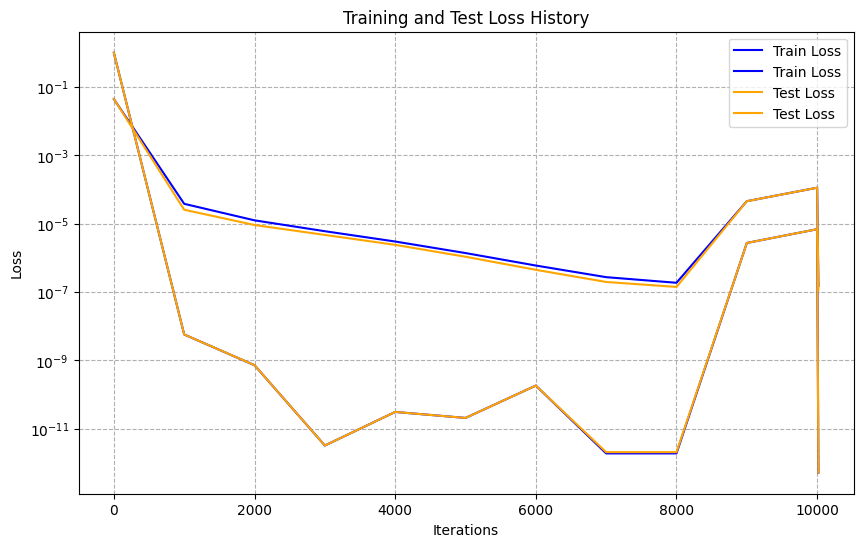

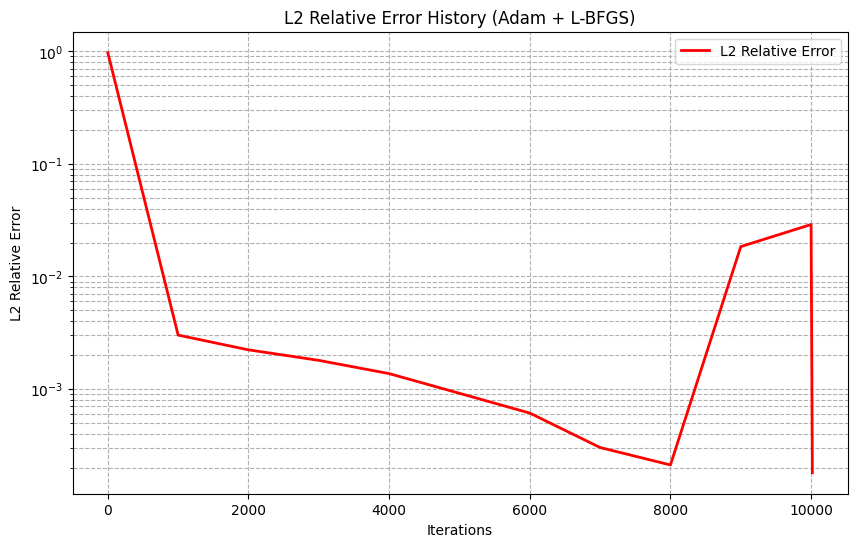

Final L2 relative error: 1.8024e-04


In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the loss history
plt.figure(figsize=(10, 6))
train_loss = np.array(losshistory_lbfgs.loss_train)
test_loss = np.array(losshistory_lbfgs.loss_test)
steps = losshistory_lbfgs.steps

plt.plot(steps, train_loss, label="Train Loss", color='blue')
plt.plot(steps, test_loss, label="Test Loss", color='orange')

plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.yscale("log")
plt.title("Training and Test Loss History")
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()


# %% cell 11.5 code

# Visualize the L2 relative error (metrics) over iterations
plt.figure(figsize=(10, 6))
metrics_test = np.array(losshistory_lbfgs.metrics_test)
steps = losshistory_lbfgs.steps

plt.plot(steps, metrics_test[:, 0], label="L2 Relative Error", color='red', linewidth=2)
plt.xlabel("Iterations")
plt.ylabel("L2 Relative Error")
plt.yscale("log")
plt.title("L2 Relative Error History (Adam + L-BFGS)")
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

print(f"Final L2 relative error: {metrics_test[-1, 0]:.4e}")

